covid19cases_test.csv:
https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a?inner_span=True

insurance data (ACS_Health_Insurance_Coverage_-_County.csv):
https://covid19-uscensus.hub.arcgis.com/datasets/acs-health-insurance-coverage-county?geometry=-133.190%2C28.795%2C133.821%2C67.148

racial population data (cc-est2019-alldata-06.csv)：
https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import numpy as np
import datetime as dt
import statsmodels.formula.api as smf

In [2]:
ca_data = pd.read_csv('data_files/covid19cases_test.csv')
ca_data = ca_data[ca_data['area_type']=='County']          # Keep only county level data
ca_data.rename(columns={'area':'county'},inplace=True)
ca_data.drop('area_type',axis=1,inplace=True)
ca_cumulative = ca_data[['reported_cases','reported_deaths','county']].groupby('county').sum()   # Get the total amount
ca_cumulative['population'] = ca_data[['population','county']].groupby('county').max()       # Get the total population

ca_cumulative['cases_percent'] = ca_cumulative['reported_cases']/ca_cumulative['population']*100
ca_cumulative['deaths_percent'] = ca_cumulative['reported_deaths']/ca_cumulative['population']*100
ca_cumulative.drop(['Out of state','Unknown'], axis=0, inplace=True)

In [3]:
ca_insu = pd.read_csv('data_files/ACS_Health_Insurance_Coverage_-_County.csv')
ca_insu = ca_insu[ca_insu['State']=='California']        # Keep data only from counties in California
ca_insu = ca_insu[['NAME','B27010_calc_pctNoInsE']]      # Keep county name column, and percent of uninsured at all
ca_insu.rename(columns={'NAME':'county','B27010_calc_pctNoInsE':'uninsured_percent'},inplace=True)

def get(name):                                           # Method used to delete "county" from "*** county"
    return name[:-7]

ca_insu['county'] = ca_insu['county'].map(get)           # Delete "county" from "*** county" in 'county' column
ca_insu.set_index('county',inplace=True)

ca_cumulative = pd.merge(left=ca_cumulative, right=ca_insu, left_on=ca_cumulative.index, right_on=ca_insu.index) #merge
ca_cumulative.set_index('key_0',inplace=True)            # Set the county name column ('ker_0' after merge) as index
ca_cumulative.sample(3)

,reported_cases,reported_deaths,population,cases_percent,deaths_percent,uninsured_percent
key_0,,,,,,
Santa Cruz,15737.0,205.0,273999.0,5.743452,0.074818,5.1
Mendocino,3729.0,46.0,88439.0,4.216466,0.052013,8.6
Inyo,1394.0,36.0,18453.0,7.554327,0.195090,5.8


/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


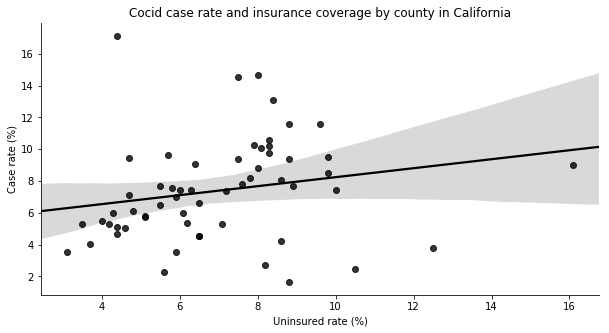

In [4]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='uninsured_percent',              # Percent of people not insured at all as independent variable
            y= 'cases_percent',                 # Percent of cases as dependent variable
            data = ca_cumulative,
            ax = ax,
            color = 'Black',
            dropna=True,
            ci = 95)                            # 95% CI                          

sns.despine(ax = ax)
                            

ax.set_title('Cocid case rate and insurance coverage by county in California')
ax.set_xlabel('Uninsured rate (%)')
ax.set_ylabel('Case rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


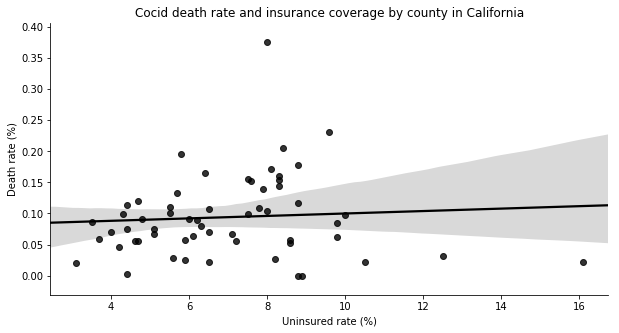

In [5]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='uninsured_percent',              # Percent of people not insured at all as independent variable
            y= 'deaths_percent',                # Percent of death as dependent variable
            data = ca_cumulative,
            ax = ax,
            color = 'Black',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid death rate and insurance coverage by county in California')
ax.set_xlabel('Uninsured rate (%)')
ax.set_ylabel('Death rate (%)')

plt.show()

In [6]:
ca_race = pd.read_csv('data_files/cc-est2019-alldata-06.csv')

# Get most updated data (7.1.2019), and get data for all age group (0 standars for all age group)
ca_race = ca_race[(ca_race['YEAR']==ca_race['YEAR'].max()) & (ca_race['AGEGRP']==0)]    

ca_race.drop(['SUMLEV','STATE','COUNTY','STNAME','TOT_MALE','TOT_FEMALE','YEAR'],axis=1,inplace=True)

ca_race['white'] = ca_race['WA_MALE']+ca_race['WA_FEMALE']        # only consider white alone here
ca_race['black'] = ca_race['BA_MALE']+ca_race['BA_FEMALE']        # only consider black alone here
ca_race['hispanic'] = ca_race['H_MALE']+ca_race['H_FEMALE']       # only consider hispanic alone here
ca_race['black_hispanic'] = ca_race['black']+ca_race['hispanic']  # the number of black alone plus hispanic alone

#The sum of race groups adds to more than the total population because individuals may report more than one race


ca_race = ca_race[['CTYNAME','TOT_POP','white','black','hispanic','black_hispanic']]    # Get useful columns
ca_race.rename(columns={'CTYNAME':'county','TOT_POP':'Population'},inplace=True)
ca_race['county'] = ca_race['county'].map(get)                    # Delete "county" from "*** county" in 'county' column        
ca_race.set_index('county',inplace=True)                          # Set county as index


ca_race['white_percent'] = ca_race['white']/ca_race['Population']*100
ca_race['black_percent'] = ca_race['black']/ca_race['Population']*100
ca_race['hispanic_percent'] = ca_race['hispanic']/ca_race['Population']*100
ca_race['black_hispanic_percent'] = ca_race['black_percent']+ca_race['hispanic_percent']

ca_race = ca_race[['white_percent','black_percent','hispanic_percent','black_hispanic_percent']]
ca_race.sample(3)

,white_percent,black_percent,hispanic_percent,black_hispanic_percent
county,,,,
Plumas,90.524805,1.074068,9.305046,10.379114
San Diego,75.408603,5.527255,34.149799,39.677054
Calaveras,90.953055,1.084849,12.998584,14.083433


In [7]:
ca_cumulative = pd.merge(left=ca_cumulative, right=ca_race, left_on=ca_cumulative.index, right_on=ca_race.index)
ca_cumulative.set_index('key_0',inplace=True)         # Set the county name column ('ker_0' after merge) as index
ca_cumulative.sample(3)

,reported_cases,reported_deaths,population,cases_percent,deaths_percent,uninsured_percent,white_percent,black_percent,hispanic_percent,black_hispanic_percent
key_0,,,,,,,,,,
Tulare,48669.0,828.0,484423.0,10.046798,0.170925,8.1,88.166969,2.182778,65.600017,67.782795
Mariposa,403.0,5.0,17795.0,2.264681,0.028098,5.6,89.310004,1.319537,12.050224,13.369761
Sutter,9302.0,110.0,105747.0,8.796467,0.104022,8.0,72.696992,2.746182,31.872415,34.618597


/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


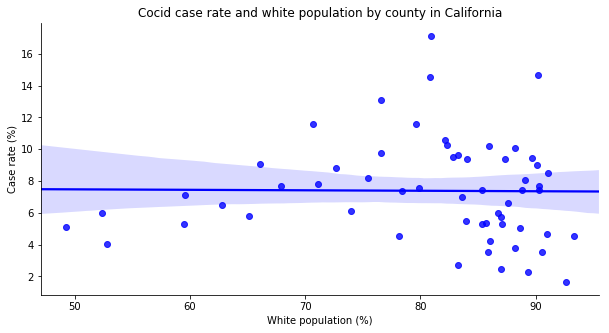

In [8]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='white_percent',                         # Percent of white population as independent variable
            y= 'cases_percent',                        # Percent of cases as dependent variable
            data = ca_cumulative,
            ax = ax,
            color = 'Blue',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid case rate and white population by county in California')
ax.set_xlabel('White population (%)')
ax.set_ylabel('Case rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


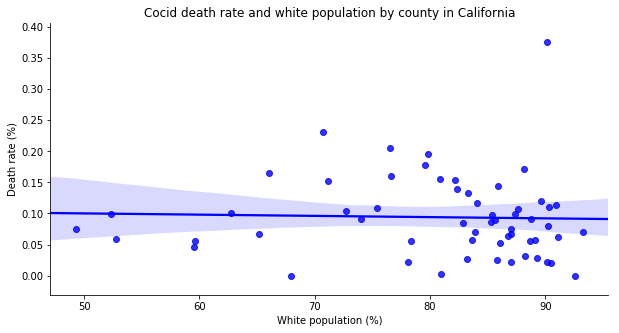

In [9]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='white_percent',                       # Percent of white population as independent variable
            y= 'deaths_percent',                     # Percent of death as independent variable
            data = ca_cumulative,
            ax = ax,
            color = 'Blue',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid death rate and white population by county in California')
ax.set_xlabel('White population (%)')
ax.set_ylabel('Death rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


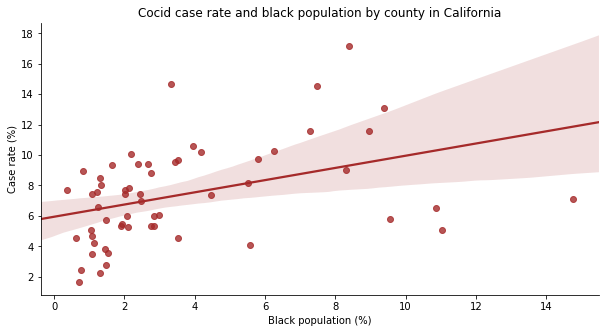

In [10]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='black_percent',                       # Percent of black population as independent variable
            y= 'cases_percent',                      # Percent of cases as dependent variable
            data = ca_cumulative,
            ax = ax,
            color = 'Brown',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid case rate and black population by county in California')
ax.set_xlabel('Black population (%)')
ax.set_ylabel('Case rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


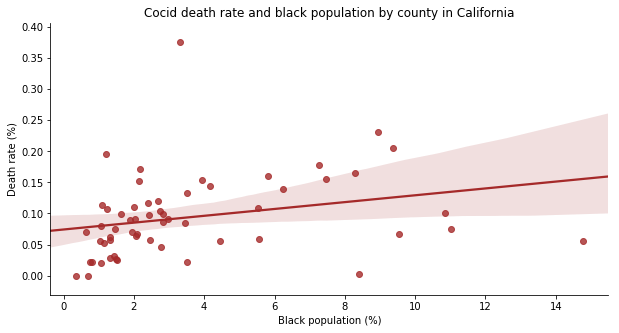

In [11]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='black_percent',                    # Percent of black population as independent variable
            y= 'deaths_percent',                  # Percent of death as dependent variable
            data = ca_cumulative,
            ax = ax,
            color = 'Brown',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid death rate and black population by county in California')
ax.set_xlabel('Black population (%)')
ax.set_ylabel('Death rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


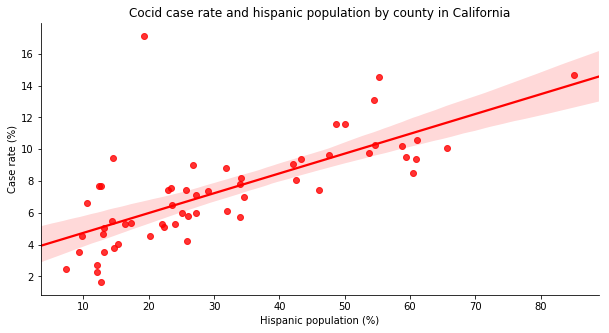

In [12]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='hispanic_percent',                  # Percent of hispanic population as independent variable
            y= 'cases_percent',                    # Percent of cases as dependent variable
            data = ca_cumulative,
            ax = ax,
            color = 'Red',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid case rate and hispanic population by county in California')
ax.set_xlabel('Hispanic population (%)')
ax.set_ylabel('Case rate (%)')

plt.show()

/Users/apple/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


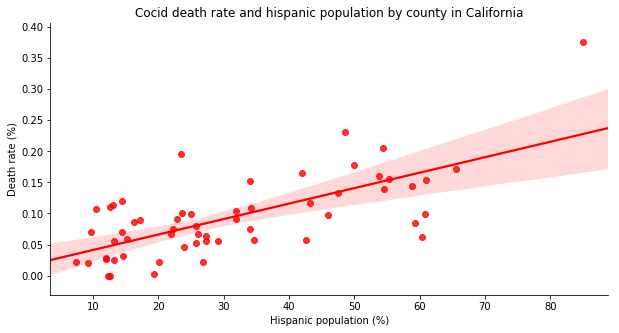

In [13]:
fig, ax = plt.subplots(figsize=(10,5)) 


sns.regplot(x='hispanic_percent',                 # Percent of hispanic population as independent variable
            y= 'deaths_percent',                  # Percent of death as dependent variable
            data = ca_cumulative,
            ax = ax,
            color = 'Red',
            dropna=True,
            ci = 95)                           

sns.despine(ax = ax)
                            

ax.set_title('Cocid death rate and hispanic population by county in California')
ax.set_xlabel('Hispanic population (%)')
ax.set_ylabel('Death rate (%)')

plt.show()

## Regression Analysis ##

In [14]:
# Since black_hispanic_percent and white_percent have strong linear relationship 
# with black_percent and hispanic_percent, in order to avoid severe multicollinearity
# we exclude black_hispanic_percent and white_percent from the independent variables.
case_result = smf.ols('cases_percent ~ uninsured_percent + black_percent + hispanic_percent', data=ca_cumulative).fit()
print(case_result.summary())

                            OLS Regression Results                            
Dep. Variable:          cases_percent   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     23.43
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           7.62e-10
Time:                        22:38:38   Log-Likelihood:                -124.64
No. Observations:                  58   AIC:                             257.3
Df Residuals:                      54   BIC:                             265.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.8302      1.00

In [15]:
death_result = smf.ols('deaths_percent ~ uninsured_percent + black_percent + hispanic_percent', data=ca_cumulative).fit()
print(death_result.summary())

                            OLS Regression Results                            
Dep. Variable:         deaths_percent   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     19.38
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           1.18e-08
Time:                        22:38:38   Log-Likelihood:                 97.386
No. Observations:                  58   AIC:                            -186.8
Df Residuals:                      54   BIC:                            -178.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0436      0.02

In [16]:
corr = ca_cumulative[['uninsured_percent','black_percent','hispanic_percent']].corr()
corr.style.background_gradient(cmap='coolwarm')
# Consider the issue of multicollinearity

,uninsured_percent,black_percent,hispanic_percent
uninsured_percent,1,-0.171511,0.357524
black_percent,-0.171511,1,0.253861
hispanic_percent,0.357524,0.253861,1
